## can we fit multiple datasets simultaneously using the DataFilters? Does the NDNT support this, or do I need to add this feature?

## imports

In [3]:
import sys
import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Invoking __init__.py for NDNT.utils
Save_dir = ./Monocular/


Loading expt01
  Time embedding...
Loading expt02
  Time embedding...
Loading expt03
  Time embedding...
Loading expt04
  Time embedding...
Loading expt05
  Time embedding...
Loading expt06
  Time embedding...
Loading expt07
  Time embedding...
Loading expt08
  Time embedding...
Loading expt09
  Time embedding...
Loading expt10
  Time embedding...
Loading expt11
  Time embedding...
Loading expt12
  Time embedding...
Loading expt13
  Time embedding...
Loading expt14
  Time embedding...
Loading expt15
  Time embedding...
Loading expt16
  Time embedding...
Loading expt17
  Time embedding...
Loading expt18
  Time embedding...
Loading expt19
  Time embedding...
Loading expt20
  Time embedding...
Loading expt21
  Time embedding...
121 cells, 7007855 time steps.


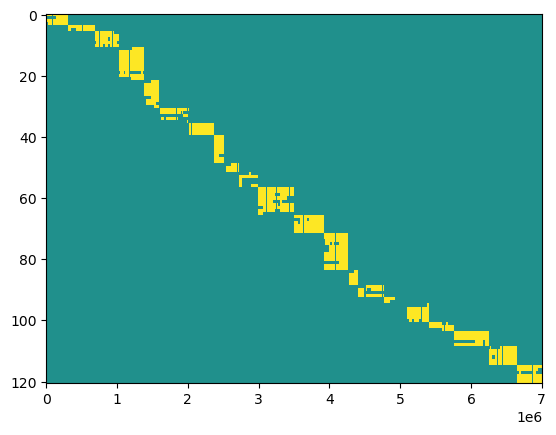

In [14]:
# Load Data
num_lags = 10
# this can handle multiple experiments
expts = ['expt0'+str(num) for num in range(1,10)] + ['expt'+str(num) for num in range(10,22)]

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

In [21]:
data.NC, data.NT

(121, 7007855)

## fit cascade model with mutliple datasets

In [17]:
# ADAM parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [18]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
#torch.cuda.empty_cache()

#data.set_cells()
#train_ds = GenericDataset(data[data.train_inds], device=device)
#val_ds = GenericDataset(data[data.val_inds], device=device)

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([72, 8])
  Layer 2:
      weight: torch.Size([72, 4])
Network 1:
  Layer 0:
      weight: torch.Size([720, 121])
      bias: torch.Size([121])


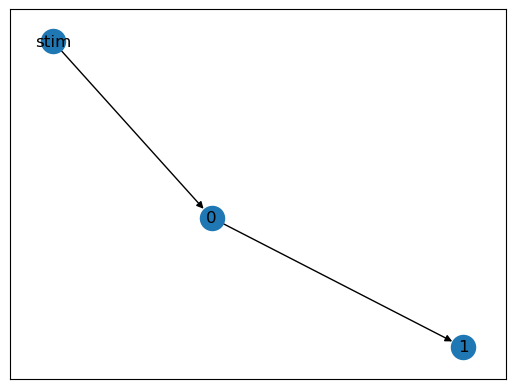

In [19]:
num_subs = [8, 8, 4]
fws = [21, 9, 9]
XTregB = 0.0001
Greg = 0.001
Creg= None
clayers = []
for ii in range(0,len(num_subs)):
    clayers.append(
        ConvLayer.layer_dict(
            num_filters=num_subs[ii], bias=False, norm_type=1, num_inh=num_subs[ii]//2,
            filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
    clayers[ii]['output_norm'] = 'batch'
    clayers[ii]['window'] = 'hamming'
clayers[0]['input_dims'] = data.stim_dims
clayers[0]['reg_vals'] = {'d2xt': XTregB, 'center': Creg, 'bcs':{'d2xt':1} }

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold',
    xstim_n = 'stim', layer_list = clayers )

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True,
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  }

readout_net = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_par], ffnet_type='normal')

cnn0 = NDN.NDN( ffnet_list=[scaffold_net, readout_net] )
m.draw_model(cnn0)
cnn0.list_parameters()

In [24]:
cnn0.networks[0].output_dims, cnn0.networks[1].input_dims

([20, 36, 1, 1], [20, 36, 1, 1])

In [20]:
cnn0.fit(data, **adam_pars, verbose=2)
LLs1 = cnn0.eval_models(data[data.val_inds], null_adjusted=True)
print(LLs1, np.mean(LLs1))

Model: M121_CCC_N

GPU Available: True, GPU Used: True


Epoch 1:  19%|███████████                                              | 500/2565 [02:54<11:59,  2.87it/s, train_loss=45]


Done fitting
  Fit complete: 174.181955575943 sec elapsed
[-1.5928745e-03 -2.4199486e-04 -1.9896030e-03 -3.1259060e-03
 -1.2311935e-03 -8.8546276e-03 -4.2288303e-03 -9.7720623e-03
 -4.2424202e-03 -8.0542564e-03 -4.5566559e-03 -3.1309128e-03
  1.6224384e-04 -2.2621155e-03 -7.7486038e-05 -2.2404194e-03
 -4.2066574e-03 -4.0340424e-04 -3.6075115e-03 -3.6997795e-02
 -7.3435307e-03 -1.7758608e-02 -1.5113354e-03 -1.9692183e-03
 -1.4007092e-04 -1.0659695e-03 -1.2490749e-03 -1.9401312e-03
 -2.3130417e-02 -4.5812130e-04 -1.1463165e-03 -1.6336441e-03
 -7.1549416e-03 -5.9673786e-03 -5.3918362e-03 -4.2734146e-03
 -3.7026405e-04 -7.2479248e-04 -1.1272669e-02 -1.1203289e-03
 -4.4224262e-03 -1.9793510e-03 -3.8799047e-03 -3.0720234e-04
 -3.1232834e-05 -1.0174513e-04 -7.6153278e-02 -1.3394356e-03
 -1.0119677e-03 -2.0580530e-02 -3.2114983e-04 -3.6470890e-03
  3.7050247e-04 -4.7802925e-04 -2.0205975e-04 -6.4711571e-03
 -5.9413910e-04 -1.7774105e-03 -2.7668476e-04 -2.5868416e-04
 -2.4461746e-04 -1.7354488e

/tmp/ipykernel_75473/1961796872.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, c+1)


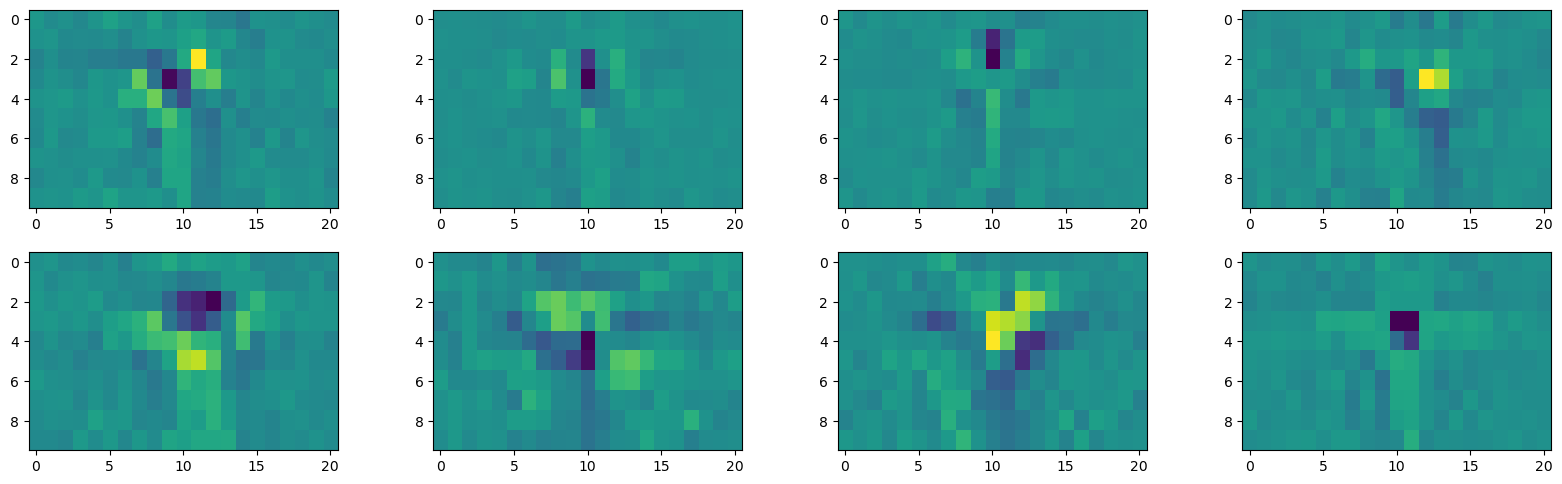

In [20]:
# plot GLM filters
ss(2, 6)
for c in range(8):
    plt.subplot(2, 4, c+1)
    imagesc(cnn0.networks[0].layers[0].get_weights()[:,:,c])
plt.show()

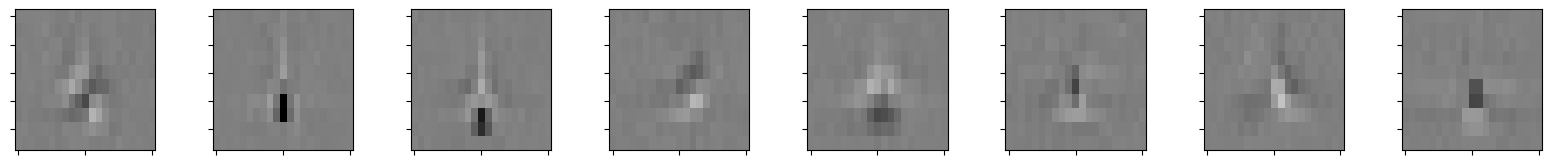

In [10]:
cnn0.plot_filters()

<Figure size 640x480 with 0 Axes>

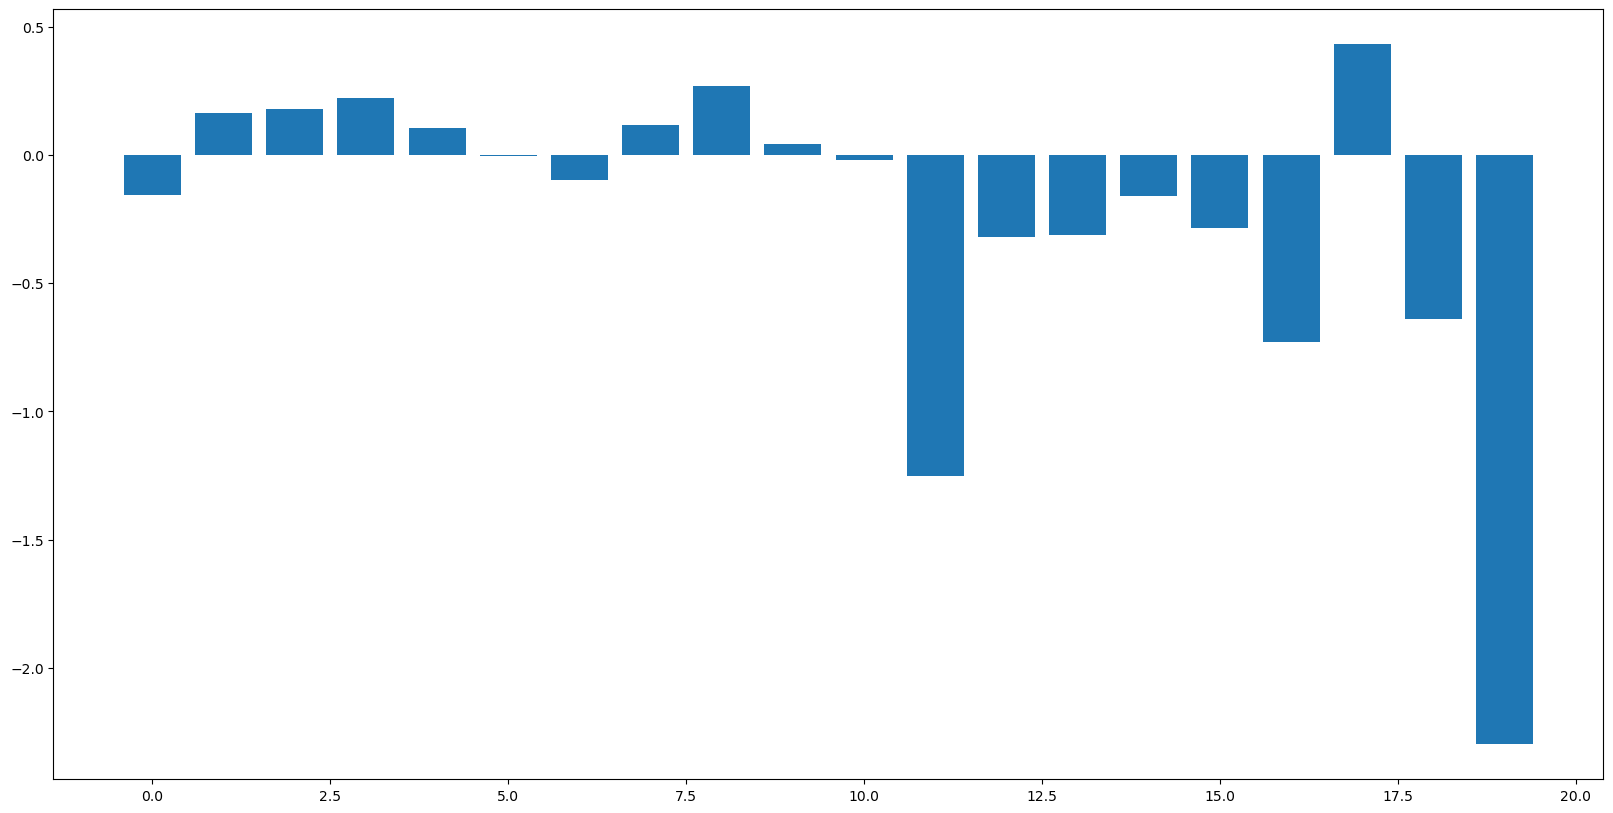

In [14]:
# R2
m.fig()
plt.bar(range(data.NC), met.r2(data, cnn0))
plt.show()

## TODO compare r2 of cells trained by themselves and with other cells

In [21]:
data.robs.shape

torch.Size([572628, 20])

## GPUtil

In [25]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 43% |
|  1 |  0% | 19% |
